In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

In [2]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_union, make_pipeline, Pipeline
from sklearn.model_selection import ParameterGrid

from sklearn.impute import MissingIndicator, KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler


from data.get_data import *

%load_ext autoreload
%autoreload 2

In [3]:
def get_classification_target(data):
    data = data.copy()
    data['returns'] = data["close"].pct_change()
    data['target'] = data['returns'].rolling(3).mean().shift(-1)
    #data['target'] = data['returns'].shift(-1)
    data['target'] = np.where(data['target'] > 0, 1, 0)
    return data['target']

In [4]:
start = "2020"
end = "2023"
data = Get_data('SOL', '1h').loc[start : end]

data.drop(columns = ['symbol'], inplace = True)
data.columns = data.columns.astype(str)

In [5]:
data['returns'] = data.close.pct_change()
data.dropna(inplace=True)
data['target'] = data['returns'].rolling(3).mean()
data['target'] = data['target'].shift(-2)
data.dropna(inplace=True)

data['target'] = np.where(data['target'] > 0, 1, 0)

data['target'] = get_classification_target(data)

data.head()

,open,high,low,close,volume,returns,target
time,,,,,,,
2020-08-11 07:00:00,2.9515,3.1355,2.8800,2.9224,42069.37,-0.009859,0
2020-08-11 08:00:00,2.9626,3.0000,2.9144,2.9600,24280.76,0.012866,0
2020-08-11 09:00:00,2.9600,2.9736,2.8500,2.8543,26371.23,-0.035709,0
2020-08-11 10:00:00,2.8566,2.9329,2.8433,2.8976,26685.94,0.015170,1
2020-08-11 11:00:00,2.9167,3.1000,2.9015,3.0497,12474.53,0.052492,1


<Axes: ylabel='target'>

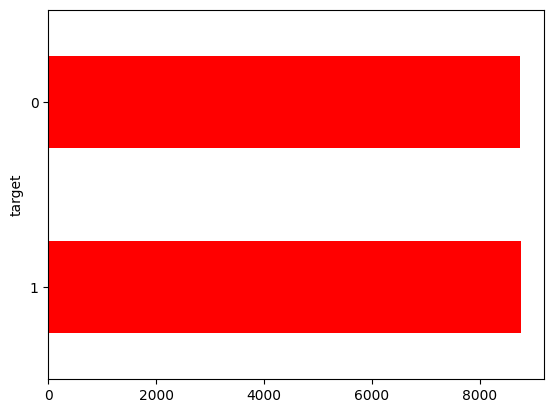

In [6]:
N = data.shape[0]
n = int(0.7*N)
train = data.loc["2021":"2022"]
test = data.loc["2023"]

features, target = train.drop(columns = ['target']), train['target']
features_test, target_test = test.drop(columns = ['target']), test['target']


target.value_counts().plot(kind = 'barh', color = 'red')

# Dense model

In [7]:
from DL import *

In [8]:
model = create_DNN_model(hl=1, hu=32, ent_dim = len(features.columns))

In [20]:
%%time
h = model.fit(features, target, epochs=50, validation_split=0.2,
          shuffle=False, verbose = 2, class_weight = cw(target))


Epoch 1/50
438/438 - 3s - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.4857 - 3s/epoch - 6ms/step
Epoch 2/50
438/438 - 2s - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.4857 - 2s/epoch - 4ms/step
Epoch 3/50
438/438 - 2s - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.4857 - 2s/epoch - 4ms/step
Epoch 4/50
438/438 - 2s - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.4857 - 2s/epoch - 5ms/step
Epoch 5/50
438/438 - 2s - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.4857 - 2s/epoch - 4ms/step
Epoch 6/50
438/438 - 1s - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.4857 - 1s/epoch - 2ms/step
Epoch 7/50
438/438 - 1s - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.4857 - 1s/epoch - 3ms/step
Epoch 8/50
438/438 - 1s - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6932 - val_accuracy: 0.4857 - 1s/epoch - 3ms/step
Epoch 9/50
438/438 - 1s 

In [10]:
model.evaluate(features, target)

548/548 [==============================] - 2s 3ms/step - loss: 25.5481 - accuracy: 0.5002


[25.548070907592773, 0.5001999139785767]

In [11]:
model.evaluate(features_test, target_test)

137/137 [==============================] - 0s 2ms/step - loss: 27.6795 - accuracy: 0.5067


[27.679502487182617, 0.5067490339279175]

In [22]:
model.predict(features, verbose=0)

array([[0.5007641],
       [0.5007641],
       [0.5007641],
       ...,
       [0.5007641],
       [0.5007641],
       [0.5007641]], dtype=float32)

In [13]:
x = np.array([3.1, 3.5])
np.amax(x)

3.5

In [14]:
df = pd.DataFrame(data = model.predict(features), columns=['predict_proba'])
df['predict'] = np.where(df['predict_proba']>0.5, 1, 0)
df

548/548 [==============================] - 2s 3ms/step


,predict_proba,predict
0,1.000000,1
1,1.000000,1
2,1.000000,1
3,0.999958,1
4,0.999997,1
...,...,...
17502,1.000000,1
17503,1.000000,1
17504,1.000000,1
17505,1.000000,1


In [15]:
df['predict'].value_counts()

predict
1    17507
Name: count, dtype: int64

In [16]:
res = pd.DataFrame(h.history)
res.head()

,loss,accuracy,val_loss,val_accuracy
0,735.855835,0.507961,218.155548,0.514278
1,243.365173,0.502178,90.422707,0.514278
2,177.958664,0.503891,349.512329,0.485722
3,278.749542,0.507747,86.187767,0.485722
4,217.059982,0.492610,11.216752,0.514278


In [17]:
px.line(res[['accuracy', 'val_accuracy']])

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'variable=accuracy<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'accuracy',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'accuracy',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                          36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], dtype=int64),
              'xaxis': 'x',
              'y': array([0.50796145, 0.50217777, 0.50389147, 0.50774723, 0.49260977, 0.50117815,
                          0.49682257, 0.49032488, 0.49432346, 0.50360584, 0.50560516, 0.50796145,
                          0.49675116, 0.50660479, 0.50938952, 0.50681901, 0.4951089 , 0.49353802,
                          0.50367725, 0.51103175, 0.5042485 , 0.50217777, 0.51203144, 0.49639416,
                          0.48903963, 0.49610853, 0.5048911 , 0.49896467, 0.49532309, 0.50146377,
                          0.50260621, 0.49582291, 0.49767941, 0.50203496, 0.50153518, 0.49532309,
                          0.50824708, 0.51453054, 0.49382365, 0.49660835, 0.49832204, 0.50467688,
                          0.50710464, 0.5018208 , 0.50082111, 0.50553375, 0.4999643 , 0.50103533,
                          0.49867904, 0.50124955]),
              'yaxis': 'y'},
             {'hovertemplate': 'variable=val_accuracy<br>index=%{x}<br>value=%{y}<extra></extra>',
              'legendgroup': 'val_accuracy',
              'line': {'color': '#EF553B', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': 'val_accuracy',
              'orientation': 'v',
              'showlegend': True,
              'type': 'scatter',
              'x': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
                          18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
                          36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49], dtype=int64),
              'xaxis': 'x',
              'y': array([0.51427758, 0.51427758, 0.48572245, 0.48572245, 0.51427758, 0.48572245,
                          0.51427758, 0.48486578, 0.51427758, 0.51427758, 0.48572245, 0.51427758,
                          0.51427758, 0.48572245, 0.48572245, 0.48572245, 0.48572245, 0.51427758,
                          0.48572245, 0.48572245, 0.51427758, 0.51427758, 0.51427758, 0.51427758,
                          0.51427758, 0.51427758, 0.48572245, 0.51427758, 0.51427758, 0.48572245,
                          0.51427758, 0.48600799, 0.48572245, 0.48572245, 0.51427758, 0.51427758,
                          0.48572245, 0.51427758, 0.48572245, 0.48572245, 0.48572245, 0.48572245,
                          0.51427758, 0.51427758, 0.48572245, 0.48572245, 0.51427758, 0.48572245,
                          0.48572245, 0.48572245]),
              'yaxis': 'y'}],
    'layout': {'legend': {'title': {'text': 'variable'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'template': '...',
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'index'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'value'}}}
})

## Backtesting

In [ ]:
def backtest(features, target, model):
    df = pd.DataFrame(data = model.predict(features), columns=['predict_proba'], index=features.index)
    df['predict'] = np.where(df['predict_proba']>0.5, 1, 0)
    df['return'] = features['returns']
    
    df['strategy'] = df['return'] * df['predict']
    df['strategy_c'] = (df['strategy'] + 1).cumprod()
    df['market'] = (df['return'] + 1).cumprod()
    fig = px.line(df[['market', 'strategy_c']])
    fig.show()


backtest(features, target, model)

In [ ]:
backtest(features_test, target_test, model)